# Vredefort sample data set from PUC-rio

#### Import libraries

In [1]:
%matplotlib inline
from IPython.display import Markdown as md
from IPython.display import display as dp
import string as st
import sys
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import datetime

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from fatiando.utils import ang2vec, vec2ang
from fatiando.mesher import Sphere, Prism, PolygonalPrism, PrismMesh
from fatiando.gravmag import sphere, prism, polyprism
from fatiando.gridder import regular

/home/andrelreis/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
notebook_name = 'vredefort_data_eqlayer.ipynb'

#### Importing auxiliary functions

In [3]:
dir_modules = '../'
sys.path.append(dir_modules)

In [4]:
import my_package as fc

## Loading data 

In [5]:
with open('data/data_set.pickle') as f:
        data = pickle.load(f)

## Loading regular grid

In [6]:
with open('data/regular_grid.pickle') as f:
        grid = pickle.load(f)

#### List of saved files

In [7]:
saved_files = []

### Parameters of acquisition

In [8]:
print 'Shape : (%.0f,%.0f)'% grid['shape'] 
print 'Number of data: %.1f' % grid['N']
print 'dx: %.1f $\mu m$' % grid['dx']
print 'dy: %.1f $\mu m$ ' % grid['dy']
print 'Height: %.1f $\mu m$' % grid['z_obs']

Shape : (121,99)
Number of data: 11979.0
dx: 300.7 $\mu m$
dy: 302.4 $\mu m$ 
Height: -1618.0 $\mu m$


In [9]:
xp,yp,zp = grid['x'],grid['y'],grid['z']

In [10]:
Y = yp.reshape(grid['shape'])
X = xp.reshape(grid['shape'])

### Visualization of data set of Vredefort sample

/home/andrelreis/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


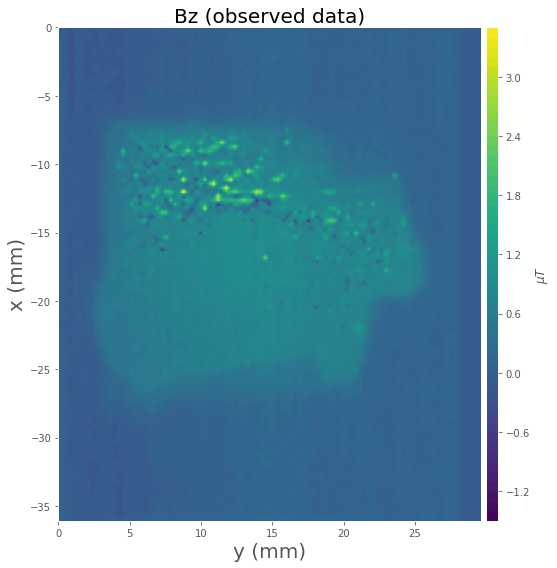

In [11]:
title_font = 20
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(8,8), tight_layout=True)
plt.style.use('ggplot')

plt.contourf(1e-3*Y.reshape(data['shape_decimated']),
             1e-3*X.reshape(data['shape_decimated']),data['obs_decimated'],50,cmap='viridis')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('$\mu T$')
plt.xlabel('y (mm)', fontsize = title_font)
plt.ylabel('x (mm)', fontsize = title_font)
plt.title('Bz (observed data)', fontsize=title_font)


file_name = 'figs/vred_data_bz'
plt.savefig(file_name+'.png',dpi=200)
saved_files.append(file_name+'.png')

plt.show()

## Generating an equivalent layer

In [12]:
inc,dec = 90.,0.

In [13]:
zc = -818.

In [14]:
xs,ys,zs = regular(grid['area'],grid['shape'],zc)

In [15]:
data_obs = data['obs_decimated'].ravel()

In [16]:
G_z = fc.sensitivity_bz(xp,yp,zp,xs,ys,zs,inc,dec)

In [17]:
mu = 1e-17
I = np.identity(grid['Nx']*grid['Ny'])

In [18]:
p = np.linalg.solve(np.dot(G_z.T,G_z) + mu*I,np.dot(G_z.T,data_obs))

## Calculating predicted data

In [19]:
bz = fc.bz_layer(xp,yp,zp,xs,ys,zs,p,inc,dec) 
bx = fc.bx_layer(xp,yp,zp,xs,ys,zs,p,inc,dec)
by = fc.by_layer(xp,yp,zp,xs,ys,zs,p,inc,dec) 

In [20]:
b_tot = np.sqrt(bx*bx + by*by + bz*bz)

In [21]:
res = data_obs - bz

### Result Analysis

### Data fitting

/home/andrelreis/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


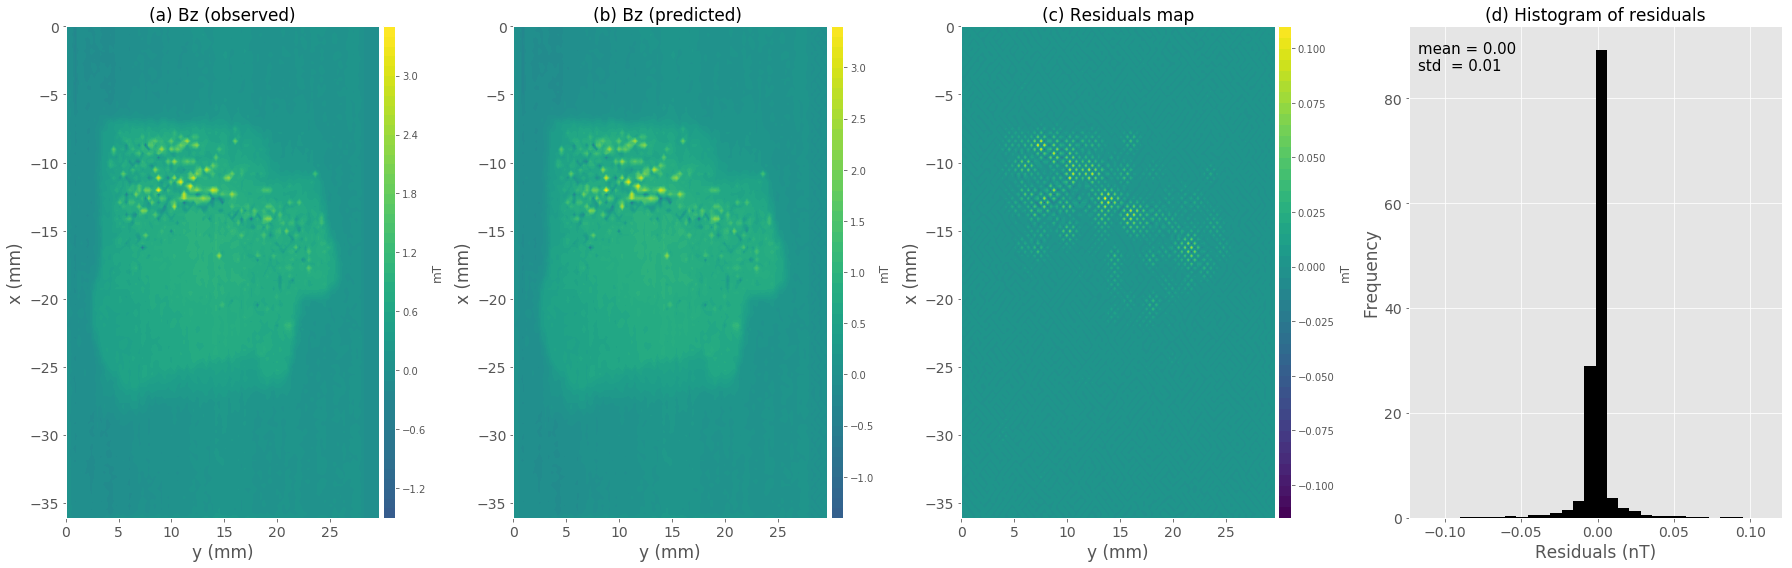

In [22]:
title_font = 17
bottom_font = 14
plt.figure(figsize=(25,8), tight_layout=True)
plt.style.use('ggplot')

ranges = np.abs([data['obs_decimated'].max(),
                 data['obs_decimated'].min()]).max()


ax1=plt.subplot(1,4,1)
plt.contourf(1e-3*Y.reshape(data['shape_decimated']),
             1e-3*X.reshape(data['shape_decimated']),
             data['obs_decimated'],50,cmap='viridis',vmin=-ranges,vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('mT')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
plt.title('(a) Bz (observed)', fontsize=title_font)
plt.xlabel('y (mm)',fontsize = title_font)
plt.ylabel('x (mm)',fontsize = title_font)

ax2=plt.subplot(1,4,2)
plt.contourf(1e-3*Y.reshape(data['shape_decimated']),
             1e-3*X.reshape(data['shape_decimated']),
             bz.reshape(data['shape_decimated']),50,cmap='viridis',vmin=-ranges,vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('mT')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
plt.title('(b) Bz (predicted) ', fontsize=title_font)
plt.xlabel('y (mm)',fontsize = title_font)
plt.ylabel('x (mm)',fontsize = title_font)

ax3=plt.subplot(1,4,3)
plt.contourf(1e-3*Y.reshape(data['shape_decimated']),
             1e-3*X.reshape(data['shape_decimated']),
             res.reshape(data['shape_decimated']),50,cmap='viridis')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('mT')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
plt.title('(c) Residuals map', fontsize=title_font)
plt.xlabel('y (mm)',fontsize = title_font)
plt.ylabel('x (mm)',fontsize = title_font)

ax4=plt.subplot(1,4,4)
plt.text(0.025, 0.97, "mean = {:.2f}\nstd  = {:.2f} ".format(np.mean(res), np.std(res)),
         horizontalalignment='left',
         verticalalignment='top',
         transform = ax4.transAxes, fontsize=15)
n, bins, patches = plt.hist(res,bins=30, normed=True, facecolor='black')
#ax4.set_xticks([-.0000008,0.0,.00000008])
#ax4.set_yticks([.0,10])
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
plt.title('(d) Histogram of residuals', fontsize =title_font)
plt.xlabel('Residuals (nT)', fontsize = title_font)
plt.ylabel('Frequency', fontsize = title_font)

########################################################################### 
file_name = 'figs/results_data_fitting_vredefort_eqlayer'
plt.savefig(file_name+'.png',dpi=400)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=400)
saved_files.append(file_name+'.eps')


plt.show()

### Visualization of components

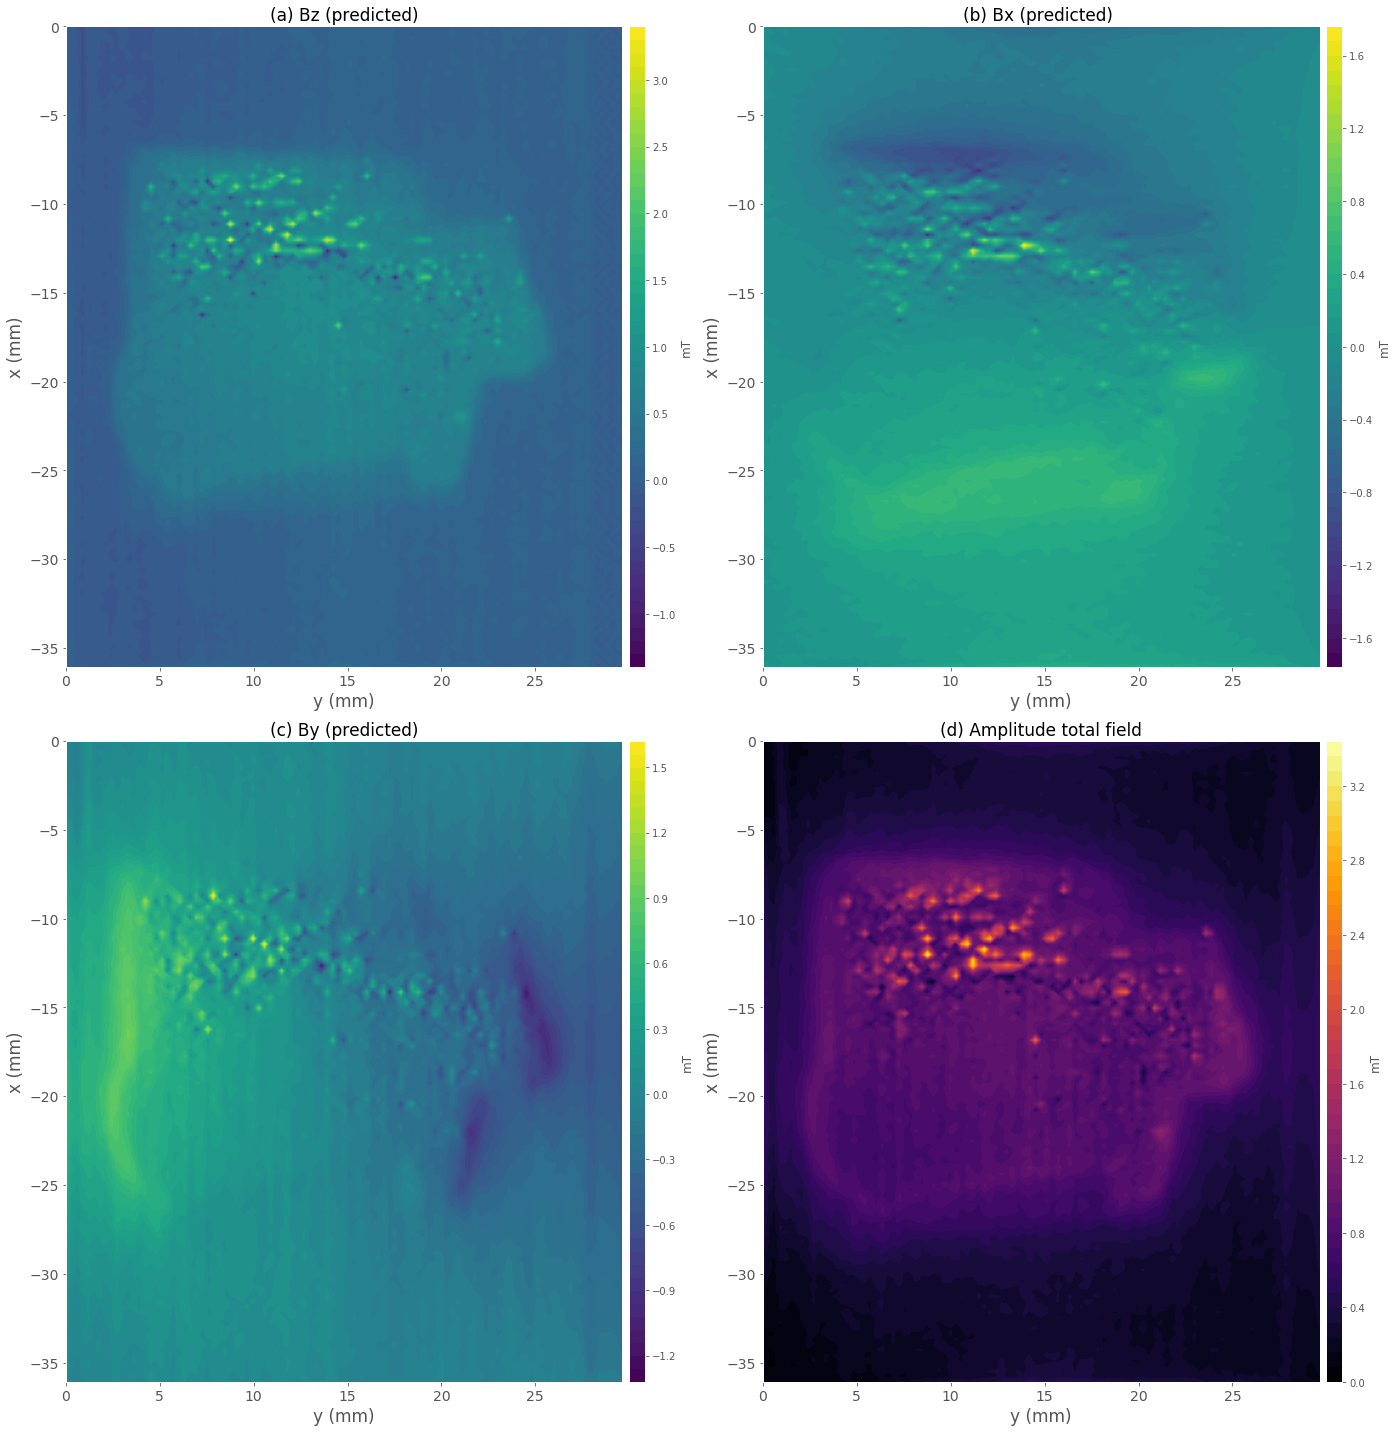

In [23]:
title_font = 17
bottom_font = 14
plt.figure(figsize=(20,20), tight_layout=True)
plt.style.use('ggplot')


ax1=plt.subplot(2,2,1)
plt.contourf(1e-3*Y.reshape(data['shape_decimated']),
             1e-3*X.reshape(data['shape_decimated']),
             bz.reshape(data['shape_decimated']),50,cmap='viridis')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('mT')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
plt.title('(a) Bz (predicted)', fontsize=title_font)
plt.xlabel('y (mm)',fontsize = title_font)
plt.ylabel('x (mm)',fontsize = title_font)

ax2=plt.subplot(2,2,2)
plt.contourf(1e-3*Y.reshape(data['shape_decimated']),
             1e-3*X.reshape(data['shape_decimated']),
             bx.reshape(data['shape_decimated']),50,cmap='viridis')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('mT')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
plt.title('(b) Bx (predicted) ', fontsize=title_font)
plt.xlabel('y (mm)',fontsize = title_font)
plt.ylabel('x (mm)',fontsize = title_font)

ax3=plt.subplot(2,2,3)
plt.contourf(1e-3*Y.reshape(data['shape_decimated']),
             1e-3*X.reshape(data['shape_decimated']),
             by.reshape(data['shape_decimated']),50,cmap='viridis')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('mT')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
plt.title('(c) By (predicted)', fontsize=title_font)
plt.xlabel('y (mm)',fontsize = title_font)
plt.ylabel('x (mm)',fontsize = title_font)

ax4=plt.subplot(2,2,4)
plt.contourf(1e-3*Y.reshape(data['shape_decimated']),
             1e-3*X.reshape(data['shape_decimated']),
             b_tot.reshape(data['shape_decimated']),50,cmap='inferno')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('mT')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
plt.title('(d) Amplitude total field', fontsize=title_font)
plt.xlabel('y (mm)',fontsize = title_font)
plt.ylabel('x (mm)',fontsize = title_font)

########################################################################### 
file_name = 'figs/field_components_vredefort_eqlayer'
plt.savefig(file_name+'.png',dpi=400)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=400)
saved_files.append(file_name+'.eps')


plt.show()